In [12]:

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats
from scipy.stats import linregress
import sacpy as scp
import cftime


In [3]:
from esmvalcore.dataset import Dataset

In [4]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    tier=2),
"ERA-Interim": 
    Dataset(
    short_name='tos',
    dataset='ERA-Interim',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20190101",
    tier=3)
}

In [5]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [6]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import monthly_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_landsea
import iris

In [7]:
def prepoc1(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = area_statistics(cube,operator='mean')
#    cube = extract_month(cube,12) # get DEC
    return cube

def prepoc2(cube):
    nino34_latext_region = {"start_longitude": 160., "end_longitude": 280., "start_latitude": -5., "end_latitude": 5.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = anomalies(cube,period='monthly')
    cube = meridional_statistics(cube,operator='mean')
#    cube = extract_month(cube,12) # get DEC
    return cube


In [8]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


In [9]:
model_n34 = model_datasets_prep1["ACCESS-ESM1-5"]
model_n34_dec = extract_month(model_datasets_prep1["ACCESS-ESM1-5"],12)
model_n34_area = model_datasets_prep2["ACCESS-ESM1-5"]

obs_n34 = obs_datasets_prep1["HadISST"]
obs_n34_dec = extract_month(obs_datasets_prep1["HadISST"],12)
obs_n34_area = obs_datasets_prep2["HadISST"]


In [10]:
# Create a CubeList with both cubes
combined_cubes = iris.cube.CubeList([model_n34, model_n34_dec, model_n34_area, obs_n34, obs_n34_dec, obs_n34_area])

# Save the CubeList to a single NetCDF file
output_filepath = '/g/data/p66/ars599/Hackathon/ENSO_recipes/n34_lifecycle_combined.nc'
#iris.save(combined_cubes, output_filepath, netcdf_format="NETCDF4")

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/fileformats/netcdf/saver.py:2625: IrisSaveWarning: Saving the cube global attributes ['Conventions', 'activity_id', 'branch_method', 'branch_time_in_child', 'branch_time_in_parent', 'cmor_version', 'conventions', 'data_specs_version', 'experiment', 'experiment_id', 'external_variables', 'forcing_index', 'frequency', 'further_info_url', 'grid', 'grid_label', 'host', 'initialization_index', 'institution', 'institution_id', 'license', 'mip_era', 'nominal_resolution', 'notes', 'parent_activity_id', 'parent_experiment_id', 'parent_mip_era', 'parent_source_id', 'parent_time_units', 'parent_variant_label', 'physics_index', 'product', 'realization_index', 'realm', 'reference', 'run_variant', 'source', 'source_id', 'source_type', 'sub_experiment', 'sub_experiment_id', 'table_id', 'table_info', 'tier', 'title', 'user', 'variable_id', 'variant_label', 'version'] as local (i.e. data-variable) attributes, where

In [31]:
import xarray as xr
ds = xr.open_dataset(output_filepath)


leadlagyr = 2
n34 = ds['tos'].squeeze()
#n34_dec = n34[11::12]
n34_dec = ds['tos_0'].squeeze()
n34_dec_ct = n34_dec[leadlagyr:-leadlagyr-1]
n34_area = ds['tos_1'].squeeze()


obs_n34 = ds['tos_2'].squeeze()
obs_n34_dec = ds['tos_3'].squeeze()
obs_n34_dec_ct = obs_n34_dec[leadlagyr:-leadlagyr-1]
obs_n34_area = ds['tos_4'].squeeze()


In [39]:
event_years = n34_dec_ct.time_0.dt.year
obs_event_years = obs_n34_dec_ct.time_2.dt.year

# Create an empty array to store the years of interest
years_of_interest_array = np.empty((len(event_years), leadlagyr*3), dtype=int)
obs_years_of_interest_array = np.empty((len(obs_event_years), leadlagyr*3), dtype=int)

# Fill the array with the years of interest for each event year
for i, year in enumerate(event_years):
    # Ensure that the selected years are not the last or second last year in the n34 dataset
    years_of_interest_array[i] = [year.values - 2, year.values - 1, year.values, year.values + 1, year.values + 2, year.values + 3]

for i, year in enumerate(obs_event_years):
    # Ensure that the selected years are not the last or second last year in the n34 dataset
    obs_years_of_interest_array[i] = [year.values - 2, year.values - 1, year.values, year.values + 1, year.values + 2, year.values + 3]


n34_selected = []
n34_area_selected = []
obs_n34_selected = []
obs_n34_area_selected = []

for i in range(len(years_of_interest_array)):
    # Select the data for the current year and append it to n34_selected
    n34_selected.append(n34.sel(time=n34['time.year'].isin(years_of_interest_array[i])))
    n34_area_selected.append(n34_area.sel(time=n34_area['time.year'].isin(years_of_interest_array[i])))

for i in range(len(years_of_interest_array_obs)):
    # Select the data for the current year and append it to n34_selected
    obs_n34_selected.append(obs_n34.sel(time_1=obs_n34['time_1.year'].isin(obs_years_of_interest_array[i])))
    obs_n34_area_selected.append(obs_n34_area.sel(time_1=obs_n34_area['time_1.year'].isin(obs_years_of_interest_array[i])))



n34_selected_array = np.array(n34_selected)  # Convert the list to a NumPy array
slope = scp.LinReg( n34_dec_ct.values, n34_selected_array).slope
slope_area = scp.LinReg( n34_dec_ct.values, n34_area_selected).slope

obs_n34_selected_array = np.array(obs_n34_selected)  # Convert the list to a NumPy array
obs_slope = scp.LinReg( obs_n34_dec_ct.values, obs_n34_selected_array).slope
obs_slope_area = scp.LinReg( obs_n34_dec_ct.values, obs_n34_area_selected).slope



# Plot the slope and correlation
# Define the lead/lag months
months = np.arange(1, 73) - 36

# Calculate the number of months where slope > 0.25 in the range -20 to 20
within_range = (months >= -30) & (months <= 30)
slope_above_025 = slope[within_range] > 0.25
num_months_above_025 = np.sum(slope_above_025)

obs_slope_above_025 = obs_slope[within_range] > 0.25
obs_num_months_above_025 = np.sum(obs_slope_above_025)

# Print with larger and thicker font
from IPython.display import display, HTML
display(HTML(f'<p style="font-size:24px; font-weight:bold;">Number of months where slope > 0.25 between -30 and 30: {num_months_above_025}</p>'))
display(HTML(f'<p style="font-size:24px; font-weight:bold;">Obs: Number of months where slope > 0.25 between -30 and 30: {obs_num_months_above_025}</p>'))
# print(f"Number of months where slope > 0.25 between -20 and 20: {num_months_above_025}")




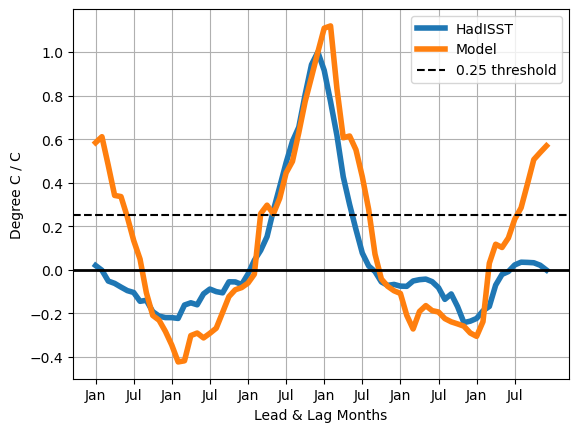

In [42]:
# Plot the slope
plt.plot(months, obs_slope, label='HadISST', lw=4)
plt.plot(months, slope, label='Model', lw=4)

# Draw a black dashed line at y=0.25
plt.axhline(y=0.25, color='black', linestyle='--', label='0.25 threshold')

# Draw a thicker line at y=0
plt.axhline(y=0, color='black', linewidth=2) #, label='Zero Line')

# Define custom ticks for the x-axis (every 6 months)
xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)

# Set the labels and titles
plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C / C')
plt.legend()
plt.grid()

# Apply the custom ticks and labels to the x-axis
plt.xticks(xticks, xtick_labels)

# Show the plot
plt.show()

# Dive down Level 2:

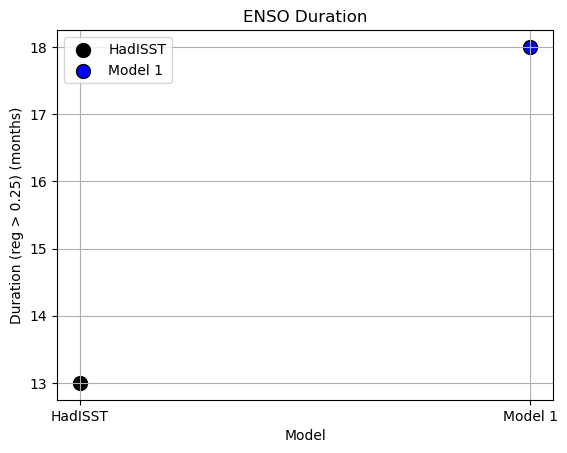

In [49]:
# Set x_position to represent the model (1, 2, or 3)
x_position = [1, 2]  # Change this to 1, 2, or 3 based on your requirement
y_position = [obs_num_months_above_025, num_months_above_025]  # Duration where slope > 0.25
label_array = ['HadISST', 'Model 1']

# Plot the HadISST duration point in black
plt.scatter(x_position[0], y_position[0], color='black', edgecolor='black', s=100, marker='o', label=label_array[0])

# Plot the Model 2 duration point in blue
plt.scatter(x_position[1], y_position[1], color='blue', edgecolor='black', s=100, marker='o', label=label_array[1])

# Set x-ticks to show 1, 2, and 3
plt.xticks([1, 2], label_array)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Duration (reg > 0.25) (months)')
plt.title('ENSO Duration')

# Optionally add a grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


# Dive down Level 3:

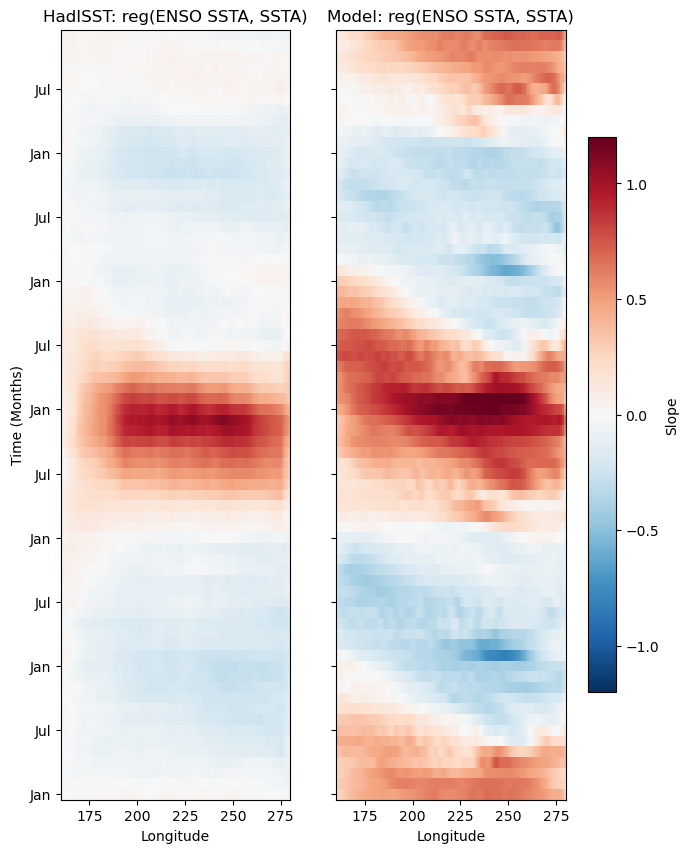

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom ticks for the y-axis (every 6 months)
yticks = range(1, 73, 6)
ytick_labels = ['Jan', 'Jul'] * (len(yticks) // 2)

# Define shared color limits for both subplots
vmin = -1.2 # min(np.min(slope_area), np.min(obs_slope_area))
vmax = 1.2 # max(np.max(slope_area), np.max(obs_slope_area))

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 10), sharey=True)

# First subplot
c1 = ax1.pcolormesh(n34_area.lon_0, range(1, 73), obs_slope_area, shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax1.set_ylabel('Time (Months)')
ax1.set_xlabel('Longitude')
ax1.set_title('HadISST: reg(ENSO SSTA, SSTA)')
ax1.set_yticks(yticks)
ax1.set_yticklabels(ytick_labels)

# Second subplot
c2 = ax2.pcolormesh(obs_n34_area.lon_2, range(1, 73), slope_area, shading='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Longitude')
ax2.set_title('Model: reg(ENSO SSTA, SSTA)')

# Adjust the layout to add more space for the colorbar on the right
plt.subplots_adjust(right=1.05)

# Add a colorbar and position it slightly to the right of the plots
cbar = fig.colorbar(c1, ax=[ax1, ax2], label='Slope', orientation='vertical', fraction=0.05, pad=0.04)

# Display the plot
#plt.tight_layout()
#plt.show()
